In [1]:
import ee
import geemap
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

try:
  ee.Initialize()
except:
  ee.Authenticate()
  ee.Initialize()

In [2]:
Map = geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [32]:
#draw a rectangle in the above map and then run this
feature = Map.draw_last_feature
roi = feature.geometry()
roi.getInfo()

{'geodesic': False,
 'type': 'Polygon',
 'coordinates': [[[-118.680299, 42.256884],
   [-118.680299, 42.266753],
   [-118.662543, 42.266753],
   [-118.662543, 42.256884],
   [-118.680299, 42.256884]]]}

In [4]:
def maskS2clouds(image):
  qa = image.select('QA60')

  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11

  mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0))

  # Return the masked and scaled data, without the QA bands.
  return image.updateMask(mask).divide(10000) 



In [33]:

# Load Sentinel-2 TOA reflectance data.
imageCollection = ee.ImageCollection('COPERNICUS/S2') \
    .filterDate('2016-01-01', '2016-12-31') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5)) \
    .map(maskS2clouds) \
    .filterBounds(roi) \
    .sort('CLOUDY_PIXEL_PERCENTAGE')


count = imageCollection.size().getInfo()
print("Total satellite images available across the date range:",count)

Total satellite images available across the date range: 37


In [34]:
#list out all the bands

rawImg = ee.Image(imageCollection.toList(imageCollection.size()).get(0))
print(rawImg.bandNames().getInfo())
type(rawImg)


['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'QA10', 'QA20', 'QA60']


ee.image.Image

In [29]:
#Process 10 meter bands

Res_ten= rawImg.select(['B2','B3','B4','B8','QA10'])
Res_ten = geemap.ee_to_numpy(Res_ten, region=roi)

print("Size - 10m:",Res_ten.shape)

targetSize = (Res_ten.shape[1],Res_ten.shape[0])


Size - 10m: (3, 5, 5)


In [15]:
#Process 20 meter bands
Res_twenty= rawImg.select(['B5','B6','B7','B8A','B11','B12','QA20'])
Res_twenty = geemap.ee_to_numpy(Res_twenty, region=roi)
print("Original Size - 20m:",Res_twenty.shape)

Res_twenty = cv2.resize(Res_twenty,targetSize,interpolation=cv2.INTER_NEAREST)
print("Resized Size  - 20m:",Res_twenty.shape)

Original Size - 20m: (2, 3, 7)
Resized Size  - 20m: (3, 5, 7)


In [18]:
#Process 60 meter bands
Res_sixty= rawImg.select(['B1','B9','B10','QA60'])
Res_sixty = geemap.ee_to_numpy(Res_sixty, region=roi)
print("Original Size - 60m:",Res_sixty.shape)

Res_sixty = cv2.resize(Res_sixty,targetSize,interpolation=cv2.INTER_NEAREST)
print("Resized Size  - 60m:",Res_sixty.shape)

Original Size - 60m: (2, 1, 4)
Resized Size  - 60m: (3, 5, 4)


In [20]:
#NDVI
NIR = geemap.ee_to_numpy(rawImg.select(['B8']), region=roi)
RED = geemap.ee_to_numpy(rawImg.select(['B4']), region=roi)
NDVI = (NIR-RED)/(NIR+RED)
NDVI.shape

(3, 5, 1)

In [26]:
#dummy season
dummy = np.zeros((targetSize[1],targetSize[0]))+1
dummy.shape,dummy

((3, 5),
 array([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]]))

In [27]:
FinalImage = np.dstack((Res_ten,NDVI,Res_twenty,Res_sixty,dummy))
FinalImage.shape

(3, 5, 18)

In [120]:
Res_sixty_Resize = resize(Res_sixty, targetSize)
Res_sixty_Resize.shape

(35, 46, 4)

In [23]:
dummy = np.zeros((targetSize[1],targetSize[0]))
dummy.shape

(3, 5)

In [130]:
FinalImage = np.dstack((Res_ten,NDVI,Res_twenty_Resize,Res_sixty_Resize,dummy))
FinalImage.shape

(35, 46, 18)

In [28]:
#get pixel value of 1st row, 1st col
FinalImage[0,0]

array([0.1646    , 0.1194    , 0.1248    , 0.1645    , 0.        ,
       0.1372278 , 0.14910001, 0.1548    , 0.1547    , 0.1719    ,
       0.1666    , 0.14139999, 0.        , 0.1743    , 0.0778    ,
       0.0017    , 0.        , 1.        ])

#Rough Testing - Don't run below cells

In [16]:
from skimage.transform import resize
b = resize(Res_twenty, (134, 189))
b.shape

(134, 189, 3)

In [31]:
b[:,:,0][:5,:5]

array([[0.1364891 , 0.1356826 , 0.13487611, 0.13509606, 0.13590256],
       [0.13675937, 0.135824  , 0.13488864, 0.13514374, 0.1360791 ],
       [0.13702964, 0.1359654 , 0.13490117, 0.13519142, 0.13625565],
       [0.13698263, 0.13594081, 0.13489899, 0.13518312, 0.13622495],
       [0.13671237, 0.13579941, 0.13488646, 0.13513545, 0.1360484 ]])

In [26]:
a[:,:,0][:5,:5]

array([[0.1345    , 0.1409    , 0.1426    , 0.14480001, 0.1436    ],
       [0.1347    , 0.13680001, 0.1428    , 0.14659999, 0.1428    ],
       [0.13240001, 0.1336    , 0.1393    , 0.14650001, 0.1441    ],
       [0.1283    , 0.1367    , 0.13339999, 0.1407    , 0.1446    ],
       [0.1313    , 0.1381    , 0.1364    , 0.13590001, 0.1392    ]])

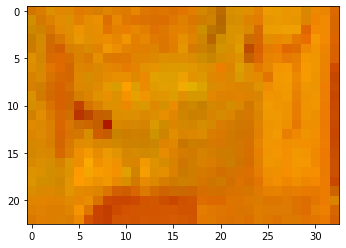

In [32]:
rgb_img = a
rgbImg = ((rgb_img - rgb_img.min()) * (1/(rgb_img.max() - rgb_img.min()) * 255)).astype('uint8')
plt.imshow(rgbImg)
plt.show()

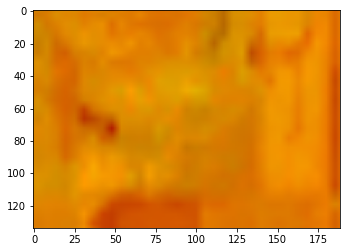

In [33]:
rgb_img = b
rgbImg = ((rgb_img - rgb_img.min()) * (1/(rgb_img.max() - rgb_img.min()) * 255)).astype('uint8')
plt.imshow(rgbImg)
plt.show()

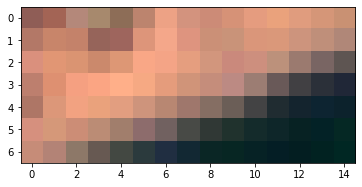

In [38]:
rgb_img = img
rgbImg = ((rgb_img - rgb_img.min()) * (1/(rgb_img.max() - rgb_img.min()) * 255)).astype('uint8')
plt.imshow(rgbImg)
plt.show()

(5, 5, 3)


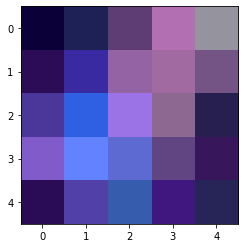

In [8]:
Res_ten= imgChn.select(['B4','B3','B2'])
Res_ten = geemap.ee_to_numpy(Res_ten, region=roi)
print(Res_ten.shape)
rgb_img = Res_ten
rgbImg = ((rgb_img - rgb_img.min()) * (1/(rgb_img.max() - rgb_img.min()) * 255)).astype('uint8')
plt.imshow(rgbImg)
plt.show()

In [14]:
import cv2
img = rgbImg
img = cv2.resize(img,(50,50),interpolation=cv2.INTER_NEAREST)

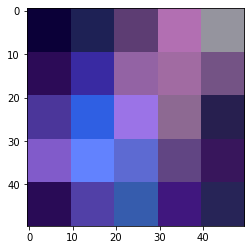

In [15]:
plt.imshow(img)
plt.show()

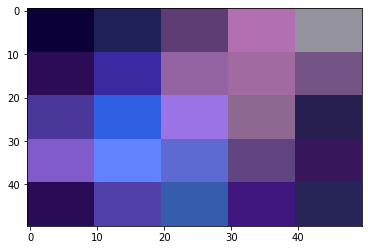

In [16]:

plt.imshow(img,aspect="auto")
plt.show()

In [24]:
imgChn = ee.Image(imageCollection.toList(imageCollection.size()).get(0))
rgb_img = geemap.ee_to_numpy(imgChn, region=roi)
print(rgb_img.shape)

(48, 47, 3)


In [25]:
rgbImg = ((rgb_img - rgb_img.min()) * (1/(rgb_img.max() - rgb_img.min()) * 255)).astype('uint8')

rgbImg.min(),rgbImg.max()

(0, 255)

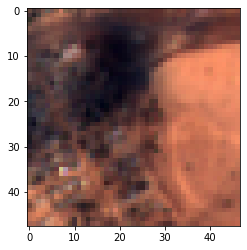

In [26]:
plt.imshow(rgbImg)
plt.show()

(114, 149, 3)


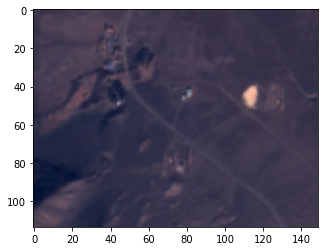

In [36]:
Res_ten= rawImg.select(['B4','B3','B2'])
Res_ten = geemap.ee_to_numpy(Res_ten, region=roi)
print(Res_ten.shape)
rgb_img = Res_ten
rgbImg = ((rgb_img - rgb_img.min()) * (1/(rgb_img.max() - rgb_img.min()) * 255)).astype('uint8')
plt.imshow(rgbImg)
plt.show()
